<a href="https://colab.research.google.com/github/iCarrrot/nn_sudoku_project/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Befor start: runtime -> change runtime type -> GPU

In [1]:
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm


try:
    from src.net import Net, train, test, get_dataloader
    from src.preprocessing import Deskewing,  split_into_cells
    from src.util import check_sudoku, sudoku, sudoku2, get_pics_path, get_gray_images
    
except ModuleNotFoundError:
    import httpimport
    with httpimport.github_repo(
            'iCarrrot', 
            'nn_sudoku_project',
            module='src',
            branch='master'
    ):
        from src.net import Net, train, test, get_dataloader
        from src.preprocessing import Deskewing,  split_into_cells, deskew_verify
        from src.util import check_sudoku, sudoku, sudoku2, get_pics_path, get_gray_images




Populating the interactive namespace from numpy and matplotlib


### TODO

* dzielenie datasetu
* downsampling obrazków
* metoda szybko printująca obrazek
* wycinanie diagramu z modyfikowanym thresholdem
* spięcie całości w metodę
* cięcie diagramu
* import sieci do rozpoznawania liczb
* konsumpcja outputu sieci

* solver: https://towardsdatascience.com/solving-sudoku-with-convolution-neural-network-keras-655ba4be3b11 
* solving krok po kroku: RNN?
* jakies ładne ogarnięcie całości

In [2]:
pics_path = get_pics_path()
gray_images, labels= get_gray_images(pics_path)
gray_images.shape

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


(101, 4160, 3120)

## Dataset

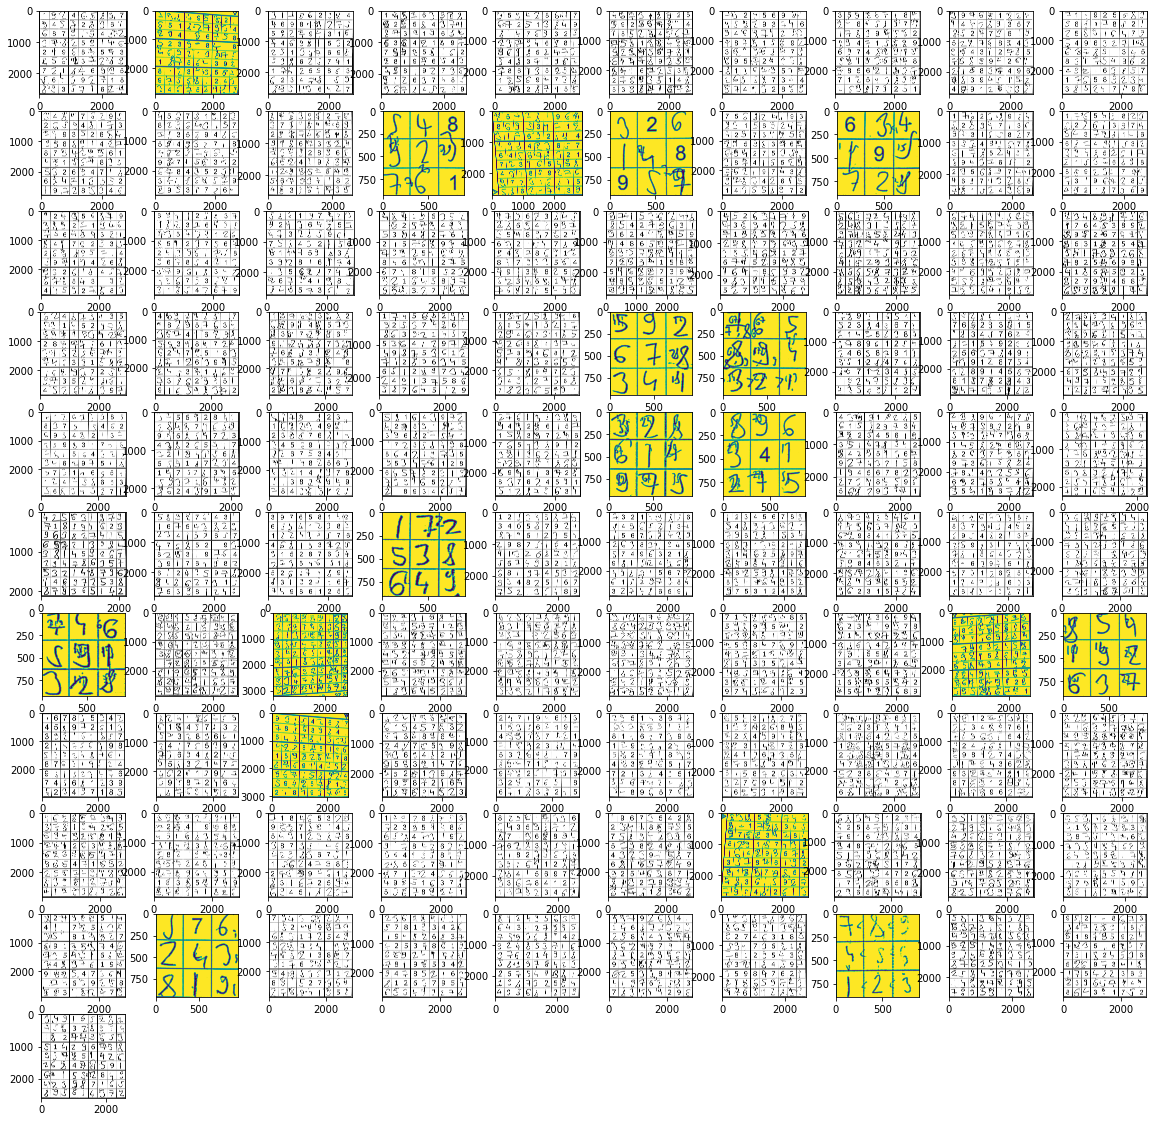

In [9]:
from src.preprocessing import Deskewing,  split_into_cells, deskew_verify
ok_ids = [0, 22, 23, 25, 26, 33]
wrong_ids = [1]
deskewed_imgs = []
desk_img_labels = []
plt.figure(figsize=(20, 20))
for i in tqdm(range(len(gray_images))):
    deskewed = Deskewing(gray_images[i])._deskew()
    plt.subplot(11, 10, i + 1)
    if i not in ok_ids and (i in wrong_ids or not deskew_verify(deskewed)):
        plt.imshow(deskewed)
    else:
        plt.imshow(deskewed, cmap='gray')
        deskewed_imgs.append(deskewed)
        desk_img_labels.append(labels[i])

(6723, 28, 28)

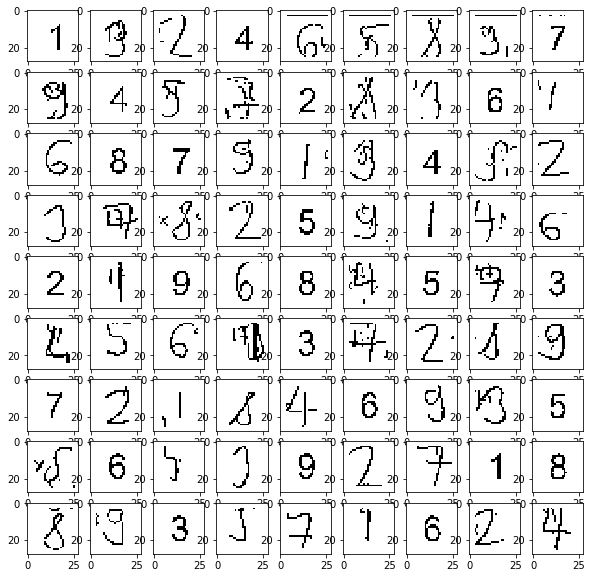

In [11]:
digits_labels = np.hstack(desk_img_labels)
digits = np.vstack([split_into_cells(x) for x in deskewed_imgs])
plt.figure(figsize=(10,10))
for i in range(81):
    plt.subplot(9, 9, i + 1)
    plt.imshow(digits[i, :, :], cmap='gray', interpolation='none')

digits.shape

## Example NN
[PyTorch MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [58]:
import torch
import torchvision


n_epochs = 3
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)



grid_dataloader = get_dataloader(digits, digits_labels, batch_size_test = batch_size_test , device='cuda')



In [59]:
model = Net()
model.to('cuda')
# train(model=model, device='cuda', train_loader=train_loader, epoch=30, optimizer=torch.optim.Adam(model.parameters()))
train(model=model, device='cuda', train_loader=grid_dataloader, epoch=30000, optimizer=torch.optim.Adam(model.parameters()))

Train Epoch: 30000 [0/6723 (0%)]	Loss: 13.402371
Train Epoch: 30000 [640/6723 (9%)]	Loss: 2.212497
Train Epoch: 30000 [1280/6723 (19%)]	Loss: 2.165747
Train Epoch: 30000 [1920/6723 (28%)]	Loss: 1.924993
Train Epoch: 30000 [2560/6723 (38%)]	Loss: 1.815566
Train Epoch: 30000 [3200/6723 (47%)]	Loss: 1.420338
Train Epoch: 30000 [3840/6723 (57%)]	Loss: 1.365589
Train Epoch: 30000 [4480/6723 (66%)]	Loss: 1.274643
Train Epoch: 30000 [5120/6723 (75%)]	Loss: 1.220384
Train Epoch: 30000 [5760/6723 (85%)]	Loss: 0.988350
Train Epoch: 30000 [6400/6723 (94%)]	Loss: 1.300858


In [60]:
prediction = test(model=model, device='cuda', test_loader=grid_dataloader)


Test set: Average loss: 0.6151, Accuracy: 5607/6723 (83%)

